In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(42)

In [2]:
df = pd.read_csv('task_2_regr.csv', index_col='id')

df.head()
df = df.dropna()

In [3]:
df.columns = df.columns.str.replace(' ', '_').str.lower() #Переименовываем колонки для более удобной работы

df['policy_start_date'] = pd.to_datetime(df['policy_start_date'])   #Преобразуем в формат даты
df['year'] = df['policy_start_date'].dt.year #Создаем числовую колонку с годом и месяцем
df['month'] = df['policy_start_date'].dt.month 

df['annual_income'] = np.log1p(df['annual_income']) #Логарифмируем чтобы приблизить к нормальному распределению


df['previous_claims'] = df['previous_claims'].dropna()

#Создаем новые фичи

df['claim_frequency'] = df['previous_claims'] / df['insurance_duration']
df['policy_ratio'] = df['insurance_duration'] / df['age']
df['credit_health'] = df['credit_score'] * df['health_score']
df['credit_health_interaction'] = df['credit_score'] * df['health_score']
df['claims_to_income_ratio'] = (df['previous_claims'] / df['annual_income']) * 10000
df['dependents_income'] = (df['number_of_dependents'] / df['annual_income']) * 10000



In [4]:
df.isna().sum()

age                          0
gender                       0
annual_income                0
marital_status               0
number_of_dependents         0
education_level              0
occupation                   0
health_score                 0
location                     0
policy_type                  0
previous_claims              0
vehicle_age                  0
credit_score                 0
insurance_duration           0
policy_start_date            0
customer_feedback            0
smoking_status               0
exercise_frequency           0
property_type                0
premium_amount               0
year                         0
month                        0
claim_frequency              0
policy_ratio                 0
credit_health                0
credit_health_interaction    0
claims_to_income_ratio       0
dependents_income            0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 384004 entries, 0 to 1199990
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   age                        384004 non-null  float64       
 1   gender                     384004 non-null  object        
 2   annual_income              384004 non-null  float64       
 3   marital_status             384004 non-null  object        
 4   number_of_dependents       384004 non-null  float64       
 5   education_level            384004 non-null  object        
 6   occupation                 384004 non-null  object        
 7   health_score               384004 non-null  float64       
 8   location                   384004 non-null  object        
 9   policy_type                384004 non-null  object        
 10  previous_claims            384004 non-null  float64       
 11  vehicle_age                384004 non-null  float64     

In [43]:
#берем 10% от датасета для обучения
train_df = df.sample(frac=0.4)

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115201 entries, 1041414 to 425352
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   age                        115201 non-null  float64       
 1   gender                     115201 non-null  object        
 2   annual_income              115201 non-null  float64       
 3   marital_status             115201 non-null  object        
 4   number_of_dependents       115201 non-null  float64       
 5   education_level            115201 non-null  object        
 6   occupation                 115201 non-null  object        
 7   health_score               115201 non-null  float64       
 8   location                   115201 non-null  object        
 9   policy_type                115201 non-null  object        
 10  previous_claims            115201 non-null  float64       
 11  vehicle_age                115201 non-null  float64

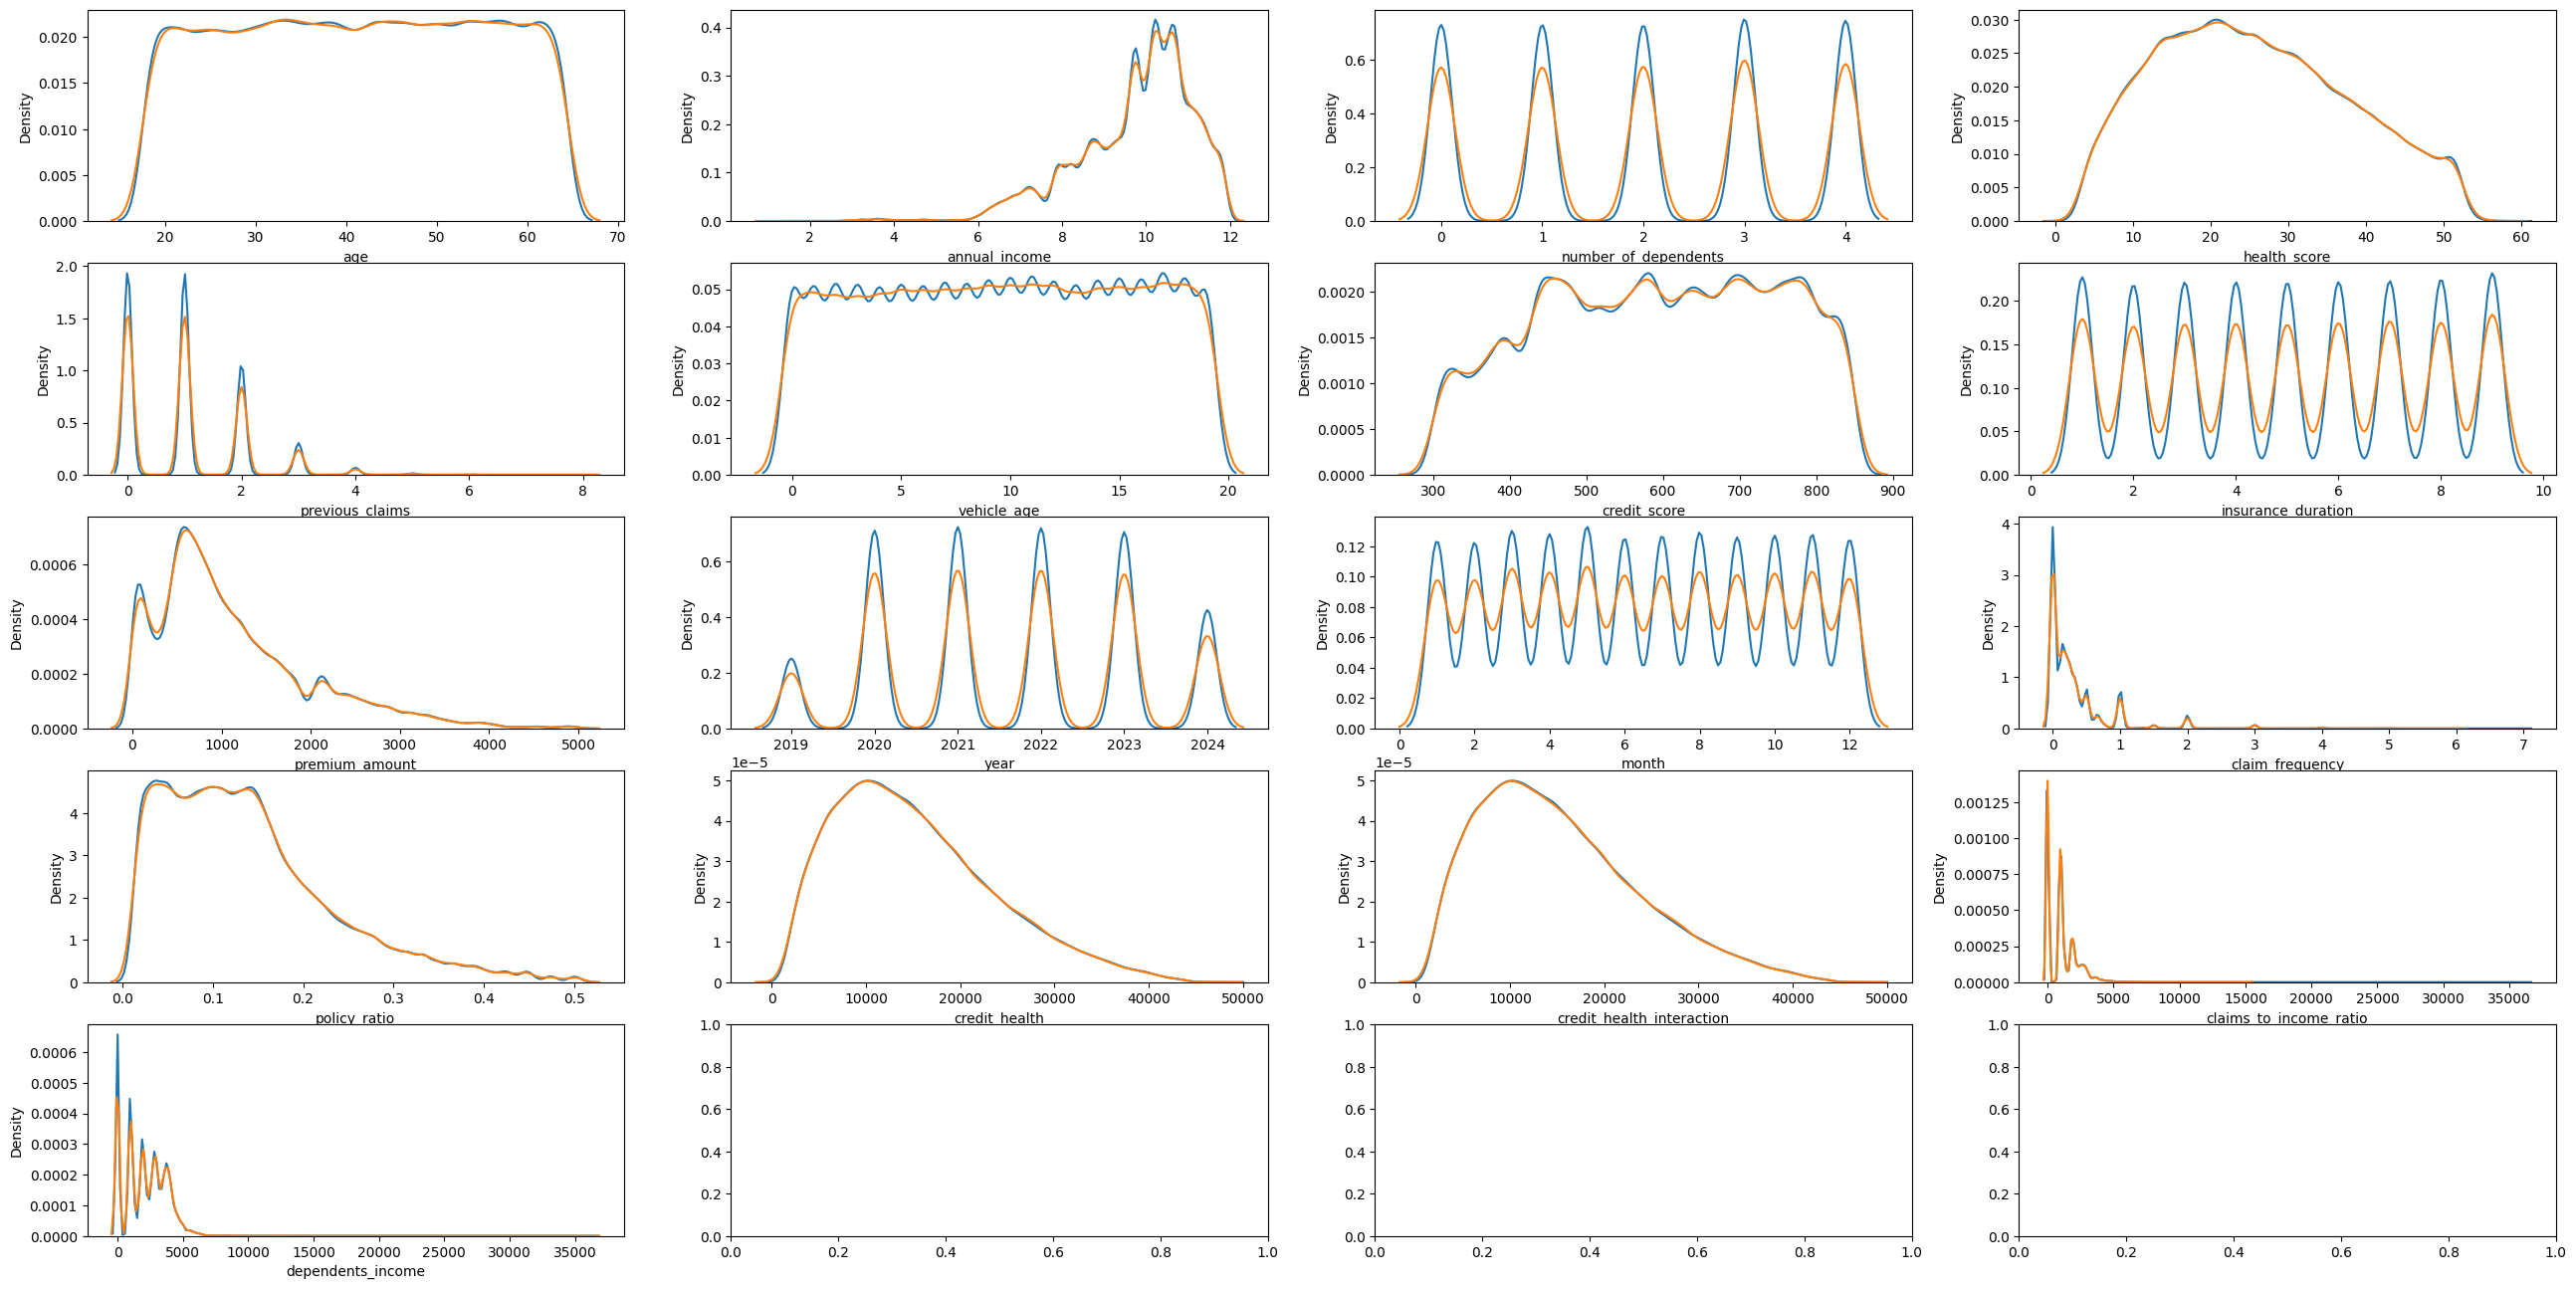

In [34]:
#Сравним распределение фичей в основном датасете и подвыборке

df_num = df.select_dtypes(include=np.number)
df_num_subsample = train_df.select_dtypes(include=np.number)

features = list(df_num.columns)
fig, axes = plt.subplots(5, len(features) // 5 + 1, figsize=(32, 16))

for axe, col in zip(axes.flatten(), features):
    sns.kdeplot(data=df_num, x=col, ax=axe)
    sns.kdeplot(data=df_num_subsample, x=col, ax=axe)


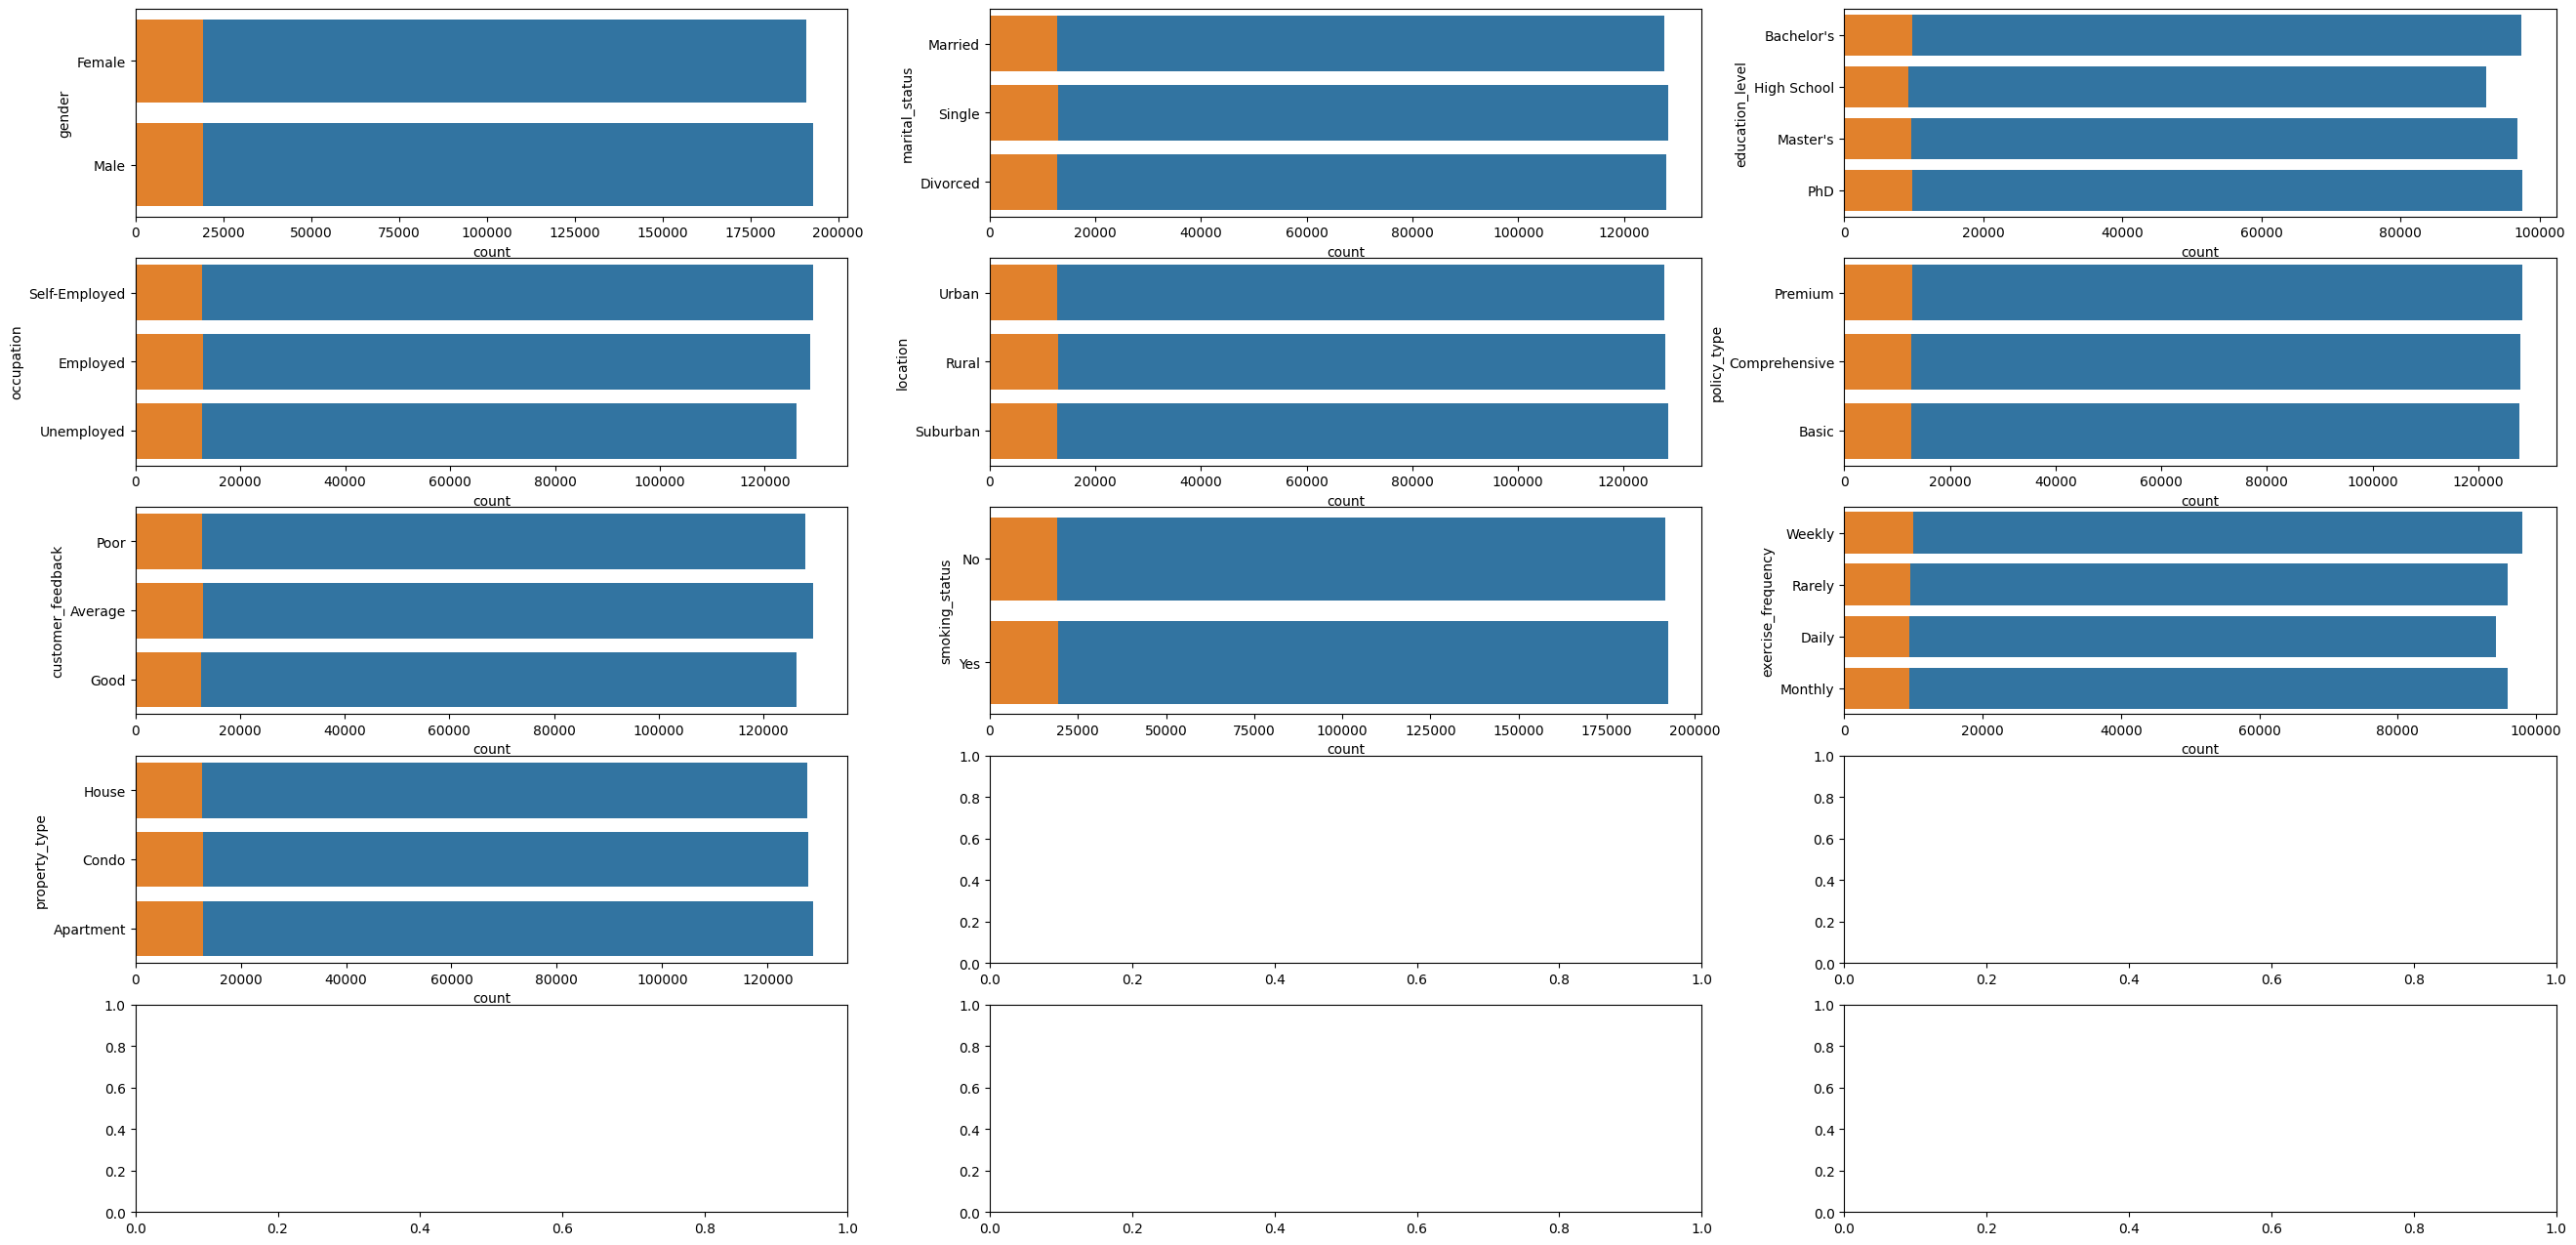

In [28]:
categorial = df.select_dtypes(include=np.object_).columns.to_list()

#Построим распределение категориальных признаков
fig, axes = plt.subplots(5, len(categorial) // 5 + 1, figsize=(32, 16))

for axe, col in zip(axes.flatten(), categorial):
    sns.countplot(data=df[col].dropna(), ax=axe)
    sns.countplot(data=train_df[col].dropna(), ax=axe)



С учетом графиков распределения будем считать что данные в подвыборке распределены так же как и в основном датасете

In [35]:
#Строим модель
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer

#Столбцы Education Level и Policy Type кодируем Ordinal Encoder (есть порядок)
#Gender Marital Status, Location через one hot (небольшое количество уникальных)


# Трансформер для категориальных признаков с OneHotEncoder
onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Трансформеры для категориальных признаков с OrdinalEncoder
education_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[["Bachelor's", 'High School', "Master's", 'PhD']]))
])

feedback_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Poor', 'Average', 'Good']])) 
])

exercise_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Rarely', 'Monthly', 'Weekly', 'Daily']])) 
])

policy_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Basic', 'Comprehensive', 'Premium']]))
])

location_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Rural', 'Suburban', 'Urban']]))
])

In [36]:
numerical_features = df.select_dtypes(include=np.number).columns.to_list()
numerical_features.remove('premium_amount')
onehot_features = ['marital_status', 'gender', 'smoking_status', 'property_type']
education_features = ['education_level']
policy_feature = ['policy_type']
feedback_feature = ['customer_feedback']
exercise_feature = ['exercise_frequency']
location_feature = ['location']

In [37]:
from sklearn.ensemble import GradientBoostingRegressor

numeric_transforms = [
    ('imputer', SimpleImputer(strategy='median')),
]

num_transformer = Pipeline(steps=numeric_transforms)

feature_preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_features),
        ('onehot', onehot_transformer, onehot_features),
        ('education', education_transformer, education_features),
        ('policy', policy_transformer, policy_feature),
        ('feedback', feedback_transformer, feedback_feature),
        ('exrcise', exercise_transformer, exercise_feature),
        ('location', location_transformer, location_feature)
    ])

model = Pipeline(steps=[
    ('preprocessor', feature_preprocessor),
    ('regression', GradientBoostingRegressor())
])


In [48]:
from sklearn.model_selection import train_test_split

x = train_df.drop(columns=['premium_amount'])
y = train_df['premium_amount']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [49]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age', 'annual_income',
                                                   'number_of_dependents',
                                                   'health_score',
                                                   'previous_claims',
                                                   'vehicle_age',
                                                   'credit_score',
                                                   'insurance_duration', 'year',
                                                   'month', 'claim_frequency',
                                                   'policy_ratio',
                                                   'credit_health',
                                                   'credit_health_interact...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Rarely',
                                                                                               'Monthly',
                                                                                               'Weekly',
                                                                                               'Daily']]))]),
                                                  ['exercise_frequency']),
                                                 ('location',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Rural',
                                                                                               'Suburban',
                                                                                               'Urban']]))]),
                                                  ['location'])])),
                ('regression', GradientBoostingRegressor())])

In [50]:
y_predict = model.predict(X_test)

In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error 

def print_score(model_name, funcs, y, y_pred):
    print(f'Score for {model_name}')
    for func in funcs:
        print(f'{func.__name__}: {func(y, y_pred):.4f}')
    print()


print_score('Gradient boosting регрессия', [mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score], y_test, y_predict)


Score for Gradient boosting регрессия
mean_absolute_error: 653.2358
mean_squared_error: 730219.6632
mean_absolute_percentage_error: 3.0674
r2_score: 0.0409



In [57]:
#подбираем оптимальные параметры для Lasso при помощи hyperopt
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
from sklearn.model_selection import cross_val_score

opt_df = train_df.sample(frac=0.2)  #используем ограниченое количество выборок для подбора параметров

X_opt = opt_df.drop(columns=['premium_amount'])
y_opt = opt_df['premium_amount']


space = {
        'n_estimators': hp.choice('n_estimators', [50, 70, 100, 120, 150]),  # Количество деревьев 
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),  # Скорость обучения 
        'max_depth': hp.choice('max_depth', [i for i in range(2, 10)])  # Максимальная глубина дерева 
}
def objective(params):

    model = Pipeline(steps=[
        ('preprocessor', feature_preprocessor),
        ('regression', GradientBoostingRegressor(**params))
    ])

    scores = cross_val_score(model, X_opt, y_opt, cv=5, scoring='neg_mean_squared_error')
    mean_score = np.mean(scores) #Усредняем оценку mse по разбивкам
    return {'loss': -mean_score, 'status': STATUS_OK}      #hyperopt ищет минимальное значение поэтому -mean_score

trials = Trials()

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

print(f'best params: {best}')

best_params = space_eval(space, best)

100%|██████████| 10/10 [07:38<00:00, 45.87s/trial, best loss: 727095.3219423445]
best params: {'learning_rate': np.float64(0.016843271171587893), 'max_depth': np.int64(5), 'n_estimators': np.int64(0)}


In [58]:

best_model = Pipeline(steps=[
    ('preprocessor', feature_preprocessor),
    ('regression', GradientBoostingRegressor(**best_params))
])

best_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age', 'annual_income',
                                                   'number_of_dependents',
                                                   'health_score',
                                                   'previous_claims',
                                                   'vehicle_age',
                                                   'credit_score',
                                                   'insurance_duration', 'year',
                                                   'month', 'claim_frequency',
                                                   'policy_ratio',
                                                   'credit_health',
                                                   'credit_health_interact...
                                                                   OrdinalEncoder(categories=[['Rarely',
                                                                                               'Monthly',
                                                                                               'Weekly',
                                                                                               'Daily']]))]),
                                                  ['exercise_frequency']),
                                                 ('location',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Rural',
                                                                                               'Suburban',
                                                                                               'Urban']]))]),
                                                  ['location'])])),
                ('regression',
                 GradientBoostingRegressor(learning_rate=0.016843271171587893,
                                           max_depth=7, n_estimators=50))])

In [60]:
y_predict = best_model.predict(X_test)

print_score('Gradient boosting регрессия best', [mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score], y_test, y_predict)


Score for Gradient boosting регрессия best
mean_absolute_error: 652.8532
mean_squared_error: 727620.6995
mean_absolute_percentage_error: 3.0692
r2_score: 0.0443

